In [10]:
# python3 genome_simulation.py --ini='bacteria.ini' --data='Escherichia_coli_DH10B.fasta'
from configparser import ConfigParser
import optparse
import random, os, sys
import pandas as pd
import numpy as np
import logging
from datetime import datetime
import numpy as np
import calendar
import time
from Bio import SeqIO 
from decimal import *
import numpy as np
import matplotlib.pyplot as plt

In [423]:
def hamming(str1, str2):
    return sum(str1 != str2 for str1, str2 in zip(str1, str2))

In [442]:
ori_seq = 'TGCTTTTCATTCTGACTGCAACGCGCAATATTTCTATCTC'
lambda_vary_type =0
conf_lamba=0.5

In [443]:
def mutate_base(ori_base, conf_lamba, bases_pool_list): #['C','A','G']
    mutated_base = np.random.choice(bases_pool_list, 1, [1-conf_lamba, conf_lamba/2, conf_lamba/2]) #Pick 1 from target list based on flip.

    return mutated_base

In [444]:
def mutation_simulate(ori_seq, conf_lamba, lambda_vary_type):
    mutated_seq = []

    if lambda_vary_type == 0: #constant lambda
        for ori_base in ori_seq:         
            #print(time, 'ori_base: ', ori_base)
            
            if ori_base == 'A' or ori_base == 'T':
                mutated_seq.append(ori_base)
            
            if ori_base == 'C': #C-> G or A
                mutated_seq.append(mutate_base(ori_base, conf_lamba, ['C','A','G']))      
                
            # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
            elif ori_base == 'G': #G-> C or T
                mutated_seq.append(mutate_base(ori_base, conf_lamba, ['G','C','T']))
                
    hamming_distance = hamming(ori_seq, mutated_seq) 
    
    return mutated_seq, hamming_distance

In [446]:
mutated_seq, hamming_distance = mutation_simulate(ori_seq, conf_lamba, lambda_vary_type)
print(list(mutated_seq))

print(ori_seq)
mutated_seq = ''.join([''.join(base) for base in mutated_seq_file_list])
print(mutated_seq)
print(hamming_distance)

['T', array(['G'], dtype='<U1'), array(['A'], dtype='<U1'), 'T', 'T', 'T', 'T', array(['A'], dtype='<U1'), 'A', 'T', 'T', array(['G'], dtype='<U1'), 'T', array(['C'], dtype='<U1'), 'A', array(['A'], dtype='<U1'), 'T', array(['G'], dtype='<U1'), array(['G'], dtype='<U1'), 'A', 'A', array(['G'], dtype='<U1'), array(['G'], dtype='<U1'), array(['C'], dtype='<U1'), array(['C'], dtype='<U1'), array(['G'], dtype='<U1'), 'A', 'A', 'T', 'A', 'T', 'T', 'T', array(['C'], dtype='<U1'), 'T', 'A', 'T', array(['C'], dtype='<U1'), 'T', array(['C'], dtype='<U1')]
TGCTTTTCATTCTGACTGCAACGCGCAATATTTCTATCTC
TCGTTTTAATTCTTACTGCAACTCGAAATATTTCTATCTG
[9]


In [126]:
def parse_file(filename, formatname, length): 
    '''
        filename: file path
        formatname: 'fasta', 'abi', 'genbank or gb' etc...
        length: top number for snipping
    '''
    with open(filename, "rU") as handle:
        for record in SeqIO.parse(handle, formatname) :
            if len(record.seq)>length:
                base_top = record.seq[:length]
        return record, base_top

In [127]:
def mutate_prob(target_bases_list, prob1): 
    picked_base = np.random.choice(target_bases_list, 1, prob1) #Pick 1 from target list based on prob1.
    return picked_base

In [128]:
def mutation_simulate(ori_seq):
    hamming_distance=0
    mutated_seq=[]

    for ori_base in ori_seq:
        flip = np.random.uniform(0, 1)
        #print('flip on ', ori_base, flip)
        
        lambda_list = list(conf_lamba)
        picked_lamba = np.random.choice(lambda_list, 1)
    
        # For C base: transit to A or G by flip probability (if flip < lamda picked randomly from configuration lambda list.)
        if (ori_base == 'C') and (flip <= picked_lamba): #C-> G or A
            mutated_base = mutate_prob(['A','G'], flip)  #Pick 1 from target list based on flip.
            hamming_distance+=1
            if mutated_base:
                #print ('(Mutated', ori_base, ' to: ', mutated_base, ' flip: ', flip, 'lambda: ', picked_lamba, ')')
                mutated_seq.append(mutated_base)   
            else:
                mutated_seq.append(ori_base)
                
        # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
        elif (ori_base == 'G') and (flip <= picked_lamba): #G-> C or T
            mutated_base = mutate_prob(['C','T'], flip)  #Pick 1 from target list based on flip.
            hamming_distance+=1
            if mutated_base:
                #print ('(Mutated', ori_base, ' to: ', mutated_base, ' flip: ', flip, 'lambda: ', picked_lamba, ')')
                mutated_seq.append(mutated_base)   
            else:
                mutated_seq.append(ori_base)            
        else:
            mutated_seq.append(ori_base)

    return mutated_seq, hamming_distance

In [130]:
#[lamba]
# conf_lamba_min/max: It is on a per generation basis ... update mutation rate to different values within the rage. 
# conf_lamba_min/max:Start by one generation the min rate then the next the max rate then the min rate etc
# conf_lamba_min=0.1 
# conf_lamba_max=0.5

# conf_lamba: can have multiple lambas
conf_lamba=0.2,0.1,0.3
conf_generation=7

#[mutation]
# run_times: How many mutated seqs will be generated.
conf_run_times=4 
conf_numrows=1

#[fasta]
# conf_filepath: The path of fasta file.
#conf_filepath = 'C:\Projects\Broad\code\FASTA\Escherichia_coli_DH10B.fasta'
conf_filepath = '../Escherichia_coli_DH10B.fasta'
# conf_top_num: How many bases could be kept from fasta file.
conf_top_num = 40 
# conf_generated_file_format: specify the format will be generated with: '.nex','.txt' etc.
conf_generated_file_format = '.txt'

In [131]:
# Get the trimmed seq string from specified file.
record, base_top = parse_file(conf_filepath, "fasta", int(conf_top_num))
ori_seq = str(base_top)
print(ori_seq)

AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG


c:\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 'U' mode is deprecated
  import sys


In [132]:
# Generate file name with timestamp.
timestamp = calendar.timegm(time.gmtime())
print(timestamp)
mut_seq_nexfilepath = "file_generated\\"+"SimSeqFile_"+ str(timestamp) + conf_generated_file_format

1565634613


In [133]:
def compare_seq(seq1, seq2):
    diff_seq = ''
    diff_index=''
    diff=''
    
    if len(seq1)==len(seq2):
        for i in range(0, len(seq1)):
            if seq1[i]!= seq2[i]:
                #diff_str+=str(i)+':'+seq1[i]+'->'+seq2[i]
                diff_seq+=seq2[i]
                diff_index+=str(i)+','
        diff = diff_seq+' '+diff_index
        
    else:
        return

    return diff.rstrip(',')

In [241]:
# Sike:
def dna_seq_compare(ori_seq, mutated_seq):
    len1 = len(ori_seq)
    len2 = len(mutated_seq)
    mismatches = []
    diff_pos = []
    
    for pos in range (0, min(len1, len2)):
        if ori_seq[pos]!= mutated_seq[pos]:
            mismatches.append("|")
            diff_pos.append(pos)
        else:
            mismatches.append(" ")
    mismatches = "".join(mismatches)
    return diff_pos, mismatches+'\n'+ mutated_seq

In [243]:
#Updated: create a dataframe to store all difference for further hamming sum caculation:
list_all_hamming = []
for i in range(0, len(ori_seq)):
    list_all_hamming.append(str(i))
    
list_all_hamming
    
df_all_hamming = pd.DataFrame(columns=list_all_hamming)
df_all_hamming

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39


In [247]:
# Generate the mutated seq, hamming distance, and mark the difference between mutated seqs and original sequence.
# Generate the dataframe with mutated seq and hamming distance.

multi_mutated_seq=''
diff_str = ''
multi_mutated_seq ='>Ori\n' + ori_seq+'\n'
df_mutseq_hamming = pd.DataFrame(columns=["id", "seq", "hamming_distance"]).append({"id":0,"seq":ori_seq, "hamming_distance":0},ignore_index=True)


for run_time in range(conf_run_times):
    #print('\nMutating...', run_time+1, 'times: ')
    mutated_seq_file_list, hamming_distance = mutation_simulate(ori_seq) #Tuple return: mutation_simulate(): mutated_seq, count. Get mutated_seq.
      
    #seq_num = 'GBAC_' + str(conf_generation)+'_'+ str(conf_lamba)
    mutated_seq = ''.join([''.join(base) for base in mutated_seq_file_list])
    multi_mutated_seq += '>Gen'+str(conf_generation)+'_'+str(run_time)+'\n'+mutated_seq+'\n'
    df_mutseq_hamming = df_mutseq_hamming.append({"id":run_time+1, "seq":mutated_seq, "hamming_distance": hamming_distance},ignore_index=True)
    print('Hamming distance: ', hamming_distance)
    
    
    diff_str += str(run_time+1)+' time(s) mutation:'+ str(dna_seq_compare(ori_seq, mutated_seq)[0])+'\n'
    
    #Sike: diff marker:
    print(ori_seq)
    str_diff_result = dna_seq_compare(ori_seq, mutated_seq)[1]+'\n'+'_______________________________________'
    
    
    print(str_diff_result)
    print()

#print(multi_mutated_seq)
print(diff_str)


Hamming distance:  2
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |                                  |  
AGATTTTCATTCTGACTGCAACGGGCAATATGTCTCTCTG
_______________________________________

Hamming distance:  5
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 |                |  |||                
ATCTTTTCATTCTGACTGGAAGTCGCAATATGTCTCTGTG
_______________________________________

Hamming distance:  5
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
           | | | |                 |    
AGCTTTTCATTATCAATCCAACGGGCAATATGTCTATGTG
_______________________________________

Hamming distance:  2
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
                               |     |  
AGCTTTTCATTCTGACTGCAACGGGCAATATCTCTCTTTG
_______________________________________

1 time(s) mutation:[2, 37]
2 time(s) mutation:[1, 18, 21, 22, 23]
3 time(s) mutation:[11, 13, 15, 17, 35]
4 time(s) mutation:[31, 37]



In [231]:
res = get_diff_column('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG', 'ACCTTTTCATTCTGACTGCAACGGGCAATATGTCTATCTC')
print(res)
print(type(res))

[1, 35, 37, 39]
<class 'list'>


In [187]:
df_mutseq_hamming

,id,seq,hamming_distance
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0
1,1,AGCTTTTCATTCTTACTGCAACGGGCAATATGTCTCTGTG,1
2,2,AGCTTTTCATTCTTACTGCAACGGGCAATATGTCTCTGTG,1
3,3,AGCTTTTCATTCTGACTGGAACTGGCAATATGTCTCTGTG,2
4,4,AGCTTTTCATTGTGACTGCAACCGGCAATATGTATCTGTG,3


### Test： 

In [20]:
conf_filepath = '../Escherichia_coli_DH10B.fasta'

In [28]:
handle = open(conf_filepath, "rU")
for fasta_record in SeqIO.parse(handle, "fasta") :
    print (fasta_record)
handle.close()

ID: NC_010473.1
Name: NC_010473.1
Description: NC_010473.1 Escherichia coli str. K12 substr. DH10B, complete genome
Number of features: 0
Seq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC', SingleLetterAlphabet())


c:\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [33]:
from Bio.Cluster import kcluster

In [34]:
sequences = [
 'ADHAMKCAIROSURBANDJVUGLOBALIZATIONANDURBANFANTASIESPLA',
'AGGESTAMKTHEARABSTATEANDNEOLIBERALGLOBALIZATIONTHEARAB',
'AGGESTAMKTHEARABSTATEANDNEOLIBERALGLOBALIZATIONTHEARAB',
'AGGESTAMKTHEARABSTATEANDNEOLIBERALGLOBALIZATIONTHEARAB']

In [35]:
matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequences])

c:\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


In [36]:
clusterid, error, nfound = kcluster(matrix)

In [37]:
print(clusterid)

[0 1 1 1]


In [56]:
import numpy as np
X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])


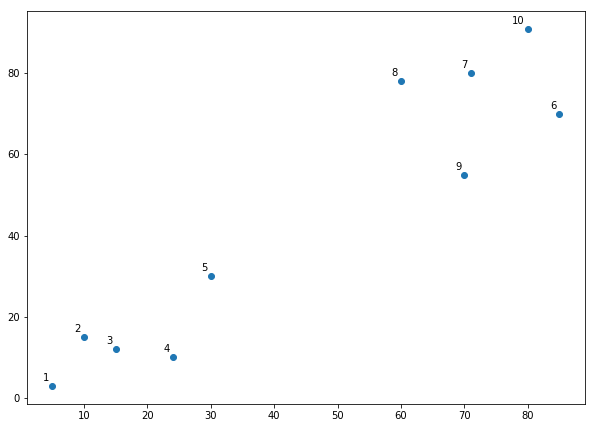

In [57]:
import matplotlib.pyplot as plt

labels = range(1, 11)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')

for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()


<class 'numpy.ndarray'>
[[ 1.          2.          5.83095189  2.        ]
 [ 3.         10.          9.21954446  3.        ]
 [ 6.          7.         11.18033989  2.        ]
 [ 0.         11.         13.          4.        ]
 [ 9.         12.         14.2126704   3.        ]
 [ 5.         14.         17.20465053  4.        ]
 [ 4.         13.         20.88061302  5.        ]
 [ 8.         15.         21.21320344  5.        ]
 [16.         17.         47.16990566 10.        ]]


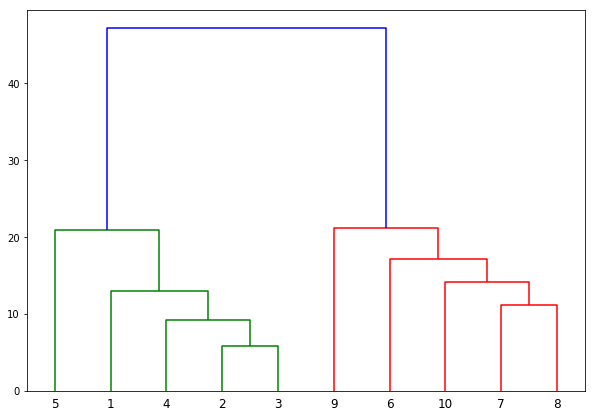

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')
print(type(linked))
print(linked)
labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

'''
X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])
'''

### Test 2

In [89]:
randomMatrix = np.random.randint(-10,10,size=(20,2))
print(randomMatrix)
print(type(randomMatrix))

[[  4  -9]
 [ -7   2]
 [-10  -1]
 [ -8   2]
 [  8   5]
 [ -8   2]
 [  8  -6]
 [ -7  -3]
 [  4   6]
 [  8   7]
 [  2  -7]
 [ -3  -4]
 [  0  -2]
 [ -7  -3]
 [  9   8]
 [  3   6]
 [  3   5]
 [ -5   7]
 [ -5   8]
 [ -7   2]]
<class 'numpy.ndarray'>


In [91]:
import scipy.spatial.distance as dis

distances = dis.pdist(randomMatrix, "hamming")
distances

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 0.5, 1. , 0.5, 1. ,
       1. , 1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 0.5, 1. , 0.5, 1. , 1. , 0.5, 1. , 1. , 1. ,
       1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       0. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. ,
       0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. , 1. , 0.5, 1. , 0.

In [84]:
randomMatrix = [0, 5, 1, 6, 3]
b=randomMatrix.iloc[:,1:].values
b

AttributeError: 'list' object has no attribute 'values'

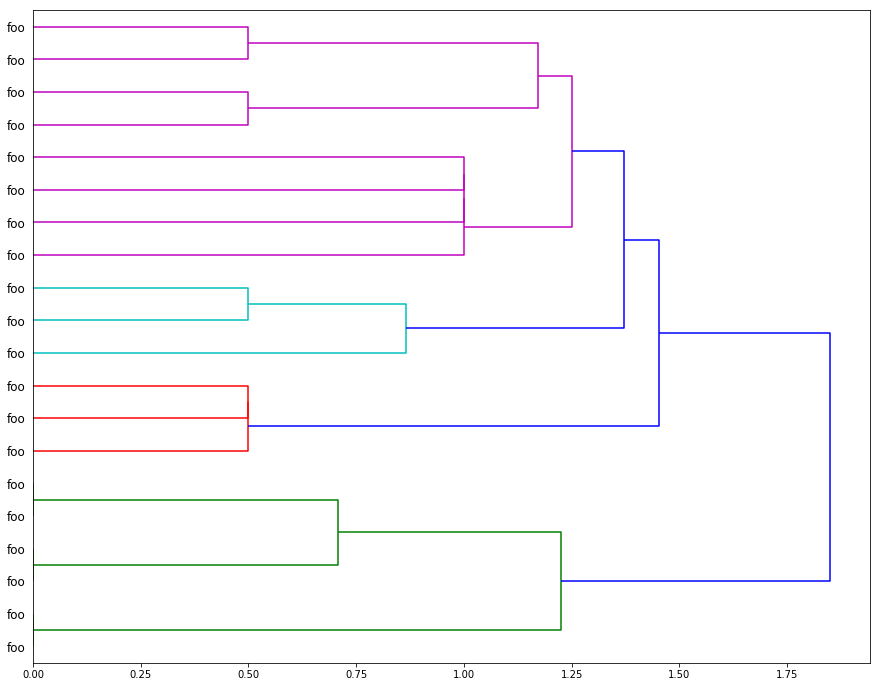

In [92]:
linked = linkage(distances, 'ward')

labelList = ["foo" for i in range(0, 20)]

plt.figure(figsize=(15, 12))
dendrogram(
            linked,
            orientation='right',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=False
          )
plt.show()

In [94]:
M = ['AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG',
 'AGGTTTTCATTCTCACTTAAACCCGCAATATGTCTGTCTT',
 'AGCTTTTCATTCTGAGTGCAAAGGGCAATATGTCTCTCTG',
 'AGATTTTCATTCTTACTCGAAAGGGAAATATTTCTCTGTC',
 'AGCTTTTGATTCTGACTTCAACCGGCAATATCTCTCTGTG']

In [95]:
import numpy as np
from scipy.cluster.hierarchy import linkage, is_valid_linkage

metric = 'hamming'
#M = np.loadtxt("z_bug_matrix.txt")
Z = linkage(M, method='average', metric='hamming')

print(is_valid_linkage(Z))

ValueError: could not convert string to float: 'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG'

#### Test 1: Hamming

In [112]:
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[10,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[10,])
X = np.concatenate((a, b),)
X

array([[ 7.92083031,  0.91717222],
       [ 7.73010982, -2.66328868],
       [10.50490885,  0.96098829],
       [10.94107044,  0.72465371],
       [ 7.14339348, -1.06199981],
       [ 8.76869882, -0.2509354 ],
       [11.38874491,  2.47956627],
       [12.75510792,  0.60249407],
       [11.17866174,  1.06841952],
       [11.10597349, -1.2137329 ],
       [-1.46245631, 20.53523022],
       [ 3.85014434, 21.65148677],
       [-2.79295681, 17.76166482],
       [-0.73545525, 19.61472985],
       [-1.99826412, 18.90973784],
       [ 2.0278176 , 19.69729695],
       [-0.6846933 , 18.11351133],
       [ 1.51264376, 18.69556713],
       [ 0.10914372, 22.16050605],
       [ 0.69313036, 20.67205548]])

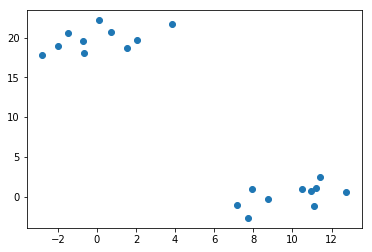

In [118]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [120]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Y=pdist(X,'hamming')

In [121]:
Y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [122]:
Z = linkage(Y, 'ward')
Z

array([[ 7.,  8.,  1.,  2.],
       [ 9., 20.,  1.,  3.],
       [ 4.,  5.,  1.,  2.],
       [ 6., 22.,  1.,  3.],
       [21., 23.,  1.,  6.],
       [10., 24.,  1.,  7.],
       [11., 25.,  1.,  8.],
       [12., 26.,  1.,  9.],
       [13., 27.,  1., 10.],
       [14., 28.,  1., 11.],
       [15., 29.,  1., 12.],
       [16., 30.,  1., 13.],
       [17., 31.,  1., 14.],
       [18., 32.,  1., 15.],
       [19., 33.,  1., 16.],
       [ 0.,  1.,  1.,  2.],
       [ 2., 35.,  1.,  3.],
       [ 3., 36.,  1.,  4.],
       [34., 37.,  1., 20.]])

In [123]:
c, coph_dists = cophenet(Z, pdist(X))
c

0.05443561194513081

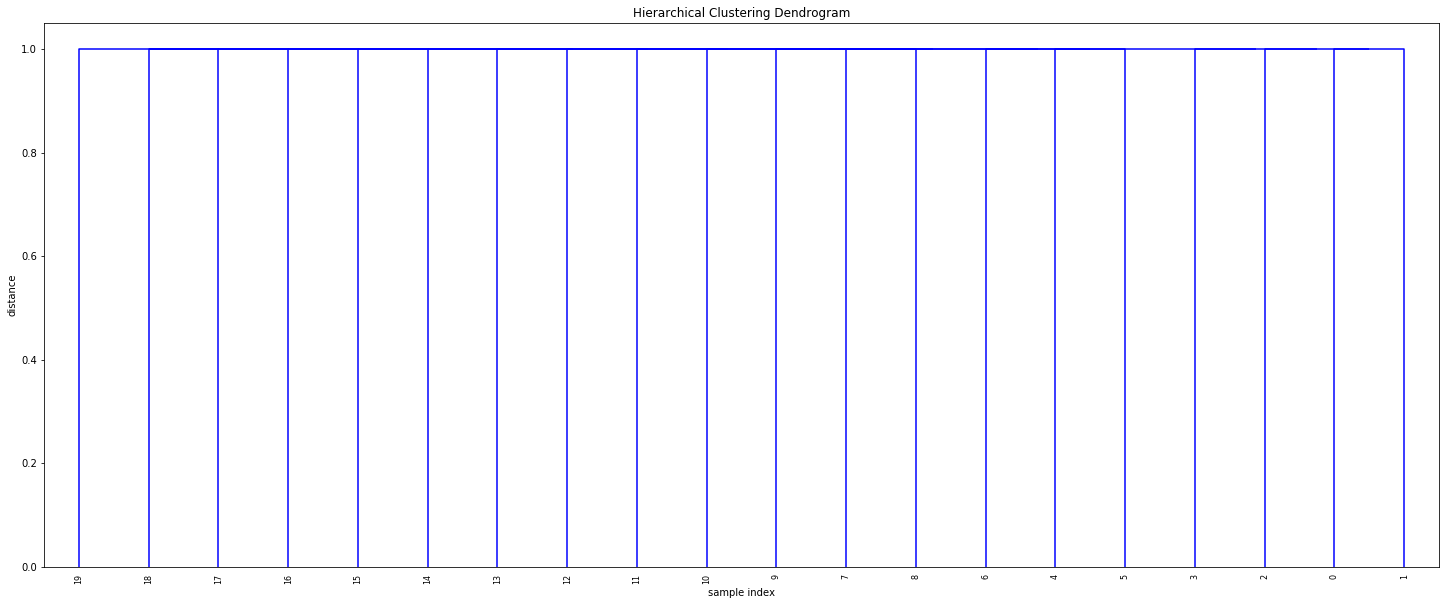

In [124]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

#### Test 3: Hamming Text

In [139]:
df_mutseq_hamming

,id,seq,hamming_distance
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0
1,1,AGCTTTTCATTCTGACTGCAACGGGCAATATGTATCTGTG,1
2,2,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTT,1
3,3,AGCTTTTCATTCTGACTTGAACGGGCAATATGTCTGTCTC,5
4,4,AGCTTTTCATTCTTAATGCAAGGGTCAATATGTCTCTTTG,5


In [148]:
array_mutseq_hamming = df_mutseq_hamming.iloc[:,1:].values
array_mutseq_hamming

array([['AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG', 0],
       ['AGCTTTTCATTCTGACTGCAACGGGCAATATGTATCTGTG', 1],
       ['AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTT', 1],
       ['AGCTTTTCATTCTGACTTGAACGGGCAATATGTCTGTCTC', 5],
       ['AGCTTTTCATTCTTAATGCAAGGGTCAATATGTCTCTTTG', 5]], dtype=object)

In [149]:
a = [['AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG',0],['AGCTTTTCATTCTGACTGCAACGGGCAATATGTATCTGTG', 1]]
b = [['AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTT',1],['AGCTTTTCATTCTGACTTGAACGGGCAATATGTCTGTCTC', 5]]
Y=dis.cdist(a,b,'hamming')
Y

ValueError: could not convert string to float: 'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG'